# **POETRY MULTICLASS**

## **Preliminary steps**

In [10]:
### PACKAGES

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

In [11]:
### FUNCTIONS

from src.configs import constants, ml_config, names
from src.libs import preprocessing, evaluation, visualization
from src.embedding.tf_idf import TfIdfEmbedding
from src.embedding.punctuation import PunctuationEmbedding
from src.classifier.classifier import LightGBMClassifier, RFClassifier, NBClassifier

## **DATA**

In [12]:
### LOAD DATA

df_poetry_gpt = preprocessing.load_dataset(source="GPT", type="POETRY")
df_poetry_bard = preprocessing.load_dataset(source="BARD", type="POETRY")
df_poetry_human = preprocessing.load_dataset(source="Human", type="POETRY")

df_essay_gpt = preprocessing.load_dataset(source="GPT", type="ESSAY")
df_essay_bard = preprocessing.load_dataset(source="BARD", type="ESSAY")
df_essay_human = preprocessing.load_dataset(source="Human", type="ESSAY")

df_story_gpt = preprocessing.load_dataset(source="GPT", type="STORY")
df_story_bard = preprocessing.load_dataset(source="BARD", type="STORY")
df_story_human = preprocessing.load_dataset(source="Human", type="STORY")

Time taken to load dataset: 0.006402254104614258 seconds
Time taken to load dataset: 0.017484664916992188 seconds
Time taken to load dataset: 0.3295400142669678 seconds
Time taken to load dataset: 0.005118608474731445 seconds
Time taken to load dataset: 0.013045072555541992 seconds
Time taken to load dataset: 0.0994727611541748 seconds
Time taken to load dataset: 0.015005350112915039 seconds
Time taken to load dataset: 0.01126241683959961 seconds
Time taken to load dataset: 0.009771585464477539 seconds


In [13]:
### GET TRAIN SPLIT

df_train_poetry_gpt, df_test_poetry_gpt = preprocessing.train_valid_split(df_poetry_gpt)
df_train_poetry_bard, df_test_poetry_bard = preprocessing.train_valid_split(
    df_poetry_bard
)
df_train_poetry_human, df_test_poetry_human = preprocessing.train_valid_split(
    df_poetry_human
)

df_train_essay_gpt, df_test_essay_gpt = preprocessing.train_valid_split(df_essay_gpt)
df_train_essay_bard, df_test_essay_bard = preprocessing.train_valid_split(df_essay_bard)
df_train_essay_human, df_test_essay_human = preprocessing.train_valid_split(
    df_essay_human
)

df_train_story_gpt, df_test_story_gpt = preprocessing.train_valid_split(df_story_gpt)
df_train_story_bard, df_test_story_bard = preprocessing.train_valid_split(df_story_bard)
df_train_story_human, df_test_story_human = preprocessing.train_valid_split(
    df_story_human
)

In [14]:
### GET FULL DATASETS

df_train_poetry = preprocessing.get_poetry_dataset(
    df_train_poetry_gpt,
    df_train_poetry_bard,
    df_train_poetry_human,
    samples_per_source=min(
        len(df_train_poetry_gpt), len(df_train_poetry_bard), len(df_train_poetry_human)
    ),
)
df_test_poetry = preprocessing.get_poetry_dataset(
    df_test_poetry_gpt,
    df_test_poetry_bard,
    df_test_poetry_human,
    samples_per_source=None,
)

df_test_essay = preprocessing.get_essay_dataset(
    df_test_essay_gpt, df_test_essay_bard, df_test_essay_human, samples_per_source=None
)

df_test_story = preprocessing.get_story_dataset(
    df_test_story_gpt, df_test_story_bard, df_test_story_human, samples_per_source=None
)

In [15]:
### SPLIT FEATURES AND LABELS

X_train_poetry, y_train_poetry = preprocessing.split_features_and_labels(
    df_train_poetry
)
X_test_poetry, y_test_poetry = preprocessing.split_features_and_labels(df_test_poetry)
X_test_essay, y_test_essay = preprocessing.split_features_and_labels(df_test_essay)
X_test_story, y_test_story = preprocessing.split_features_and_labels(df_test_story)

## **CLASSIFICATION USING PUNCTUATION & RANDOM FOREST**

In [16]:
ID_EXPERIMENT = 211

In [17]:
### EMBEDDING

embedding_211 = PunctuationEmbedding(ID_EXPERIMENT)

X_train_poetry_211 = embedding_211.transform(X=X_train_poetry)
X_test_poetry_211 = embedding_211.transform(X=X_test_poetry)
X_test_essay_211 = embedding_211.transform(X=X_test_essay)
X_test_story_211 = embedding_211.transform(X=X_test_story)

In [18]:
### CLASSIFIER

classifier_211 = LightGBMClassifier(ID_EXPERIMENT)

classifier_211.train(X_train=X_train_poetry_211, y_train=y_train_poetry)

metrics_poetry_211 = classifier_211.evaluate(X_test_poetry_211, y_test_poetry)
metrics_essay_211 = classifier_211.evaluate(X_test_essay_211, y_test_essay)
metrics_story_211 = classifier_211.evaluate(X_test_story_211, y_test_story)

print(f"Metrics on poetry: {metrics_poetry_211}")
print(f"Metrics on essay: {metrics_essay_211}")
print(f"Metrics on story: {metrics_story_211}")

Metrics on poetry: {'accuracy': 0.6917613636363636, 'precision': 0.355076760373261, 'recall': 0.5376777939042089, 'f1': 0.31607519281365176}
Metrics on essay: {'accuracy': 0.7121771217712177, 'precision': 0.2992248062015504, 'recall': 0.26045883940620784, 'f1': 0.2784992784992785}
Metrics on story: {'accuracy': 0.2727272727272727, 'precision': 0.25510204081632654, 'recall': 0.35555555555555557, 'f1': 0.2306547619047619}


In [19]:
### INTERPRETABILITY - FEATURE IMPORTANCE

dim_names_211 = embedding_211.map_dimensions_to_names()
feature_importances_211 = classifier_211.get_feature_importance()
most_important_features_211 = np.argsort(feature_importances_211)[-10:][::-1]
for i in most_important_features_211:
    print(f"{dim_names_211[i]}: {feature_importances_211[i]}")

ratio_words_per_sentence: 2648
ratio_odd_characters: 2161
ratio_punctuations: 2099


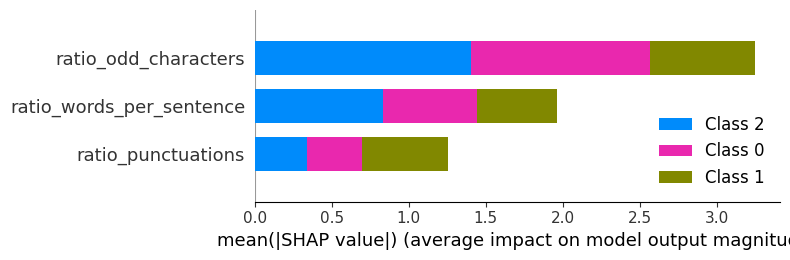

In [20]:
### INTERPRETABILITY - SHAP VALUES

explainer_211 = shap.Explainer(classifier_211.classifier)

if hasattr(X_test_poetry_211, "toarray"):
    X_test_poetry_211 = X_test_poetry_211.toarray()

# Calculate SHAP values
shap_values_211 = explainer_211(X_test_poetry_211)

# Visualize the SHAP values
shap.summary_plot(shap_values_211, X_test_poetry_211, feature_names=dim_names_211)

## **CLASSIFICATION USING TF-IDF & LGBM**

In [21]:
ID_EXPERIMENT = 111

In [22]:
### EMBEDDING

embedding_111 = TfIdfEmbedding(ID_EXPERIMENT)

embedding_111.fit(X=X_train_poetry)

X_train_poetry_111 = embedding_111.transform(X=X_train_poetry)
X_test_poetry_111 = embedding_111.transform(X=X_test_poetry)
X_test_essay_111 = embedding_111.transform(X=X_test_essay)
X_test_story_111 = embedding_111.transform(X=X_test_story)

In [23]:
### CLASSIFIER

classifier_111 = LightGBMClassifier(ID_EXPERIMENT)

classifier_111.train(X_train=X_train_poetry_111, y_train=y_train_poetry)

metrics_poetry_111 = classifier_111.evaluate(X_test_poetry_111, y_test_poetry)
metrics_essay_111 = classifier_111.evaluate(X_test_essay_111, y_test_essay)
metrics_story_111 = classifier_111.evaluate(X_test_story_111, y_test_story)

print(f"Metrics on poetry: {metrics_poetry_111}")
print(f"Metrics on essay: {metrics_essay_111}")
print(f"Metrics on story: {metrics_story_111}")

Metrics on poetry: {'accuracy': 0.9303977272727273, 'precision': 0.44665807921621875, 'recall': 0.8041702951136913, 'f1': 0.5035830389488926}
Metrics on essay: {'accuracy': 0.6826568265682657, 'precision': 0.29790660225442833, 'recall': 0.2496626180836707, 'f1': 0.27165932452276065}
Metrics on story: {'accuracy': 0.4909090909090909, 'precision': 0.7196581196581198, 'recall': 0.47777777777777786, 'f1': 0.4112233445566778}


In [24]:
### INTERPRETABILITY - FEATURE IMPORTANCE

dim_names_111 = embedding_111.map_dimensions_to_names()
feature_importances_111 = classifier_111.get_feature_importance()
most_important_features_111 = np.argsort(feature_importances_111)[-10:][::-1]
for i in most_important_features_111:
    print(f"{dim_names_111[i]}: {feature_importances_111[i]}")

like: 199
world: 190
let: 170
oh: 162
heart: 143
peace: 136
beauty: 132
life: 122
know: 121
hope: 120


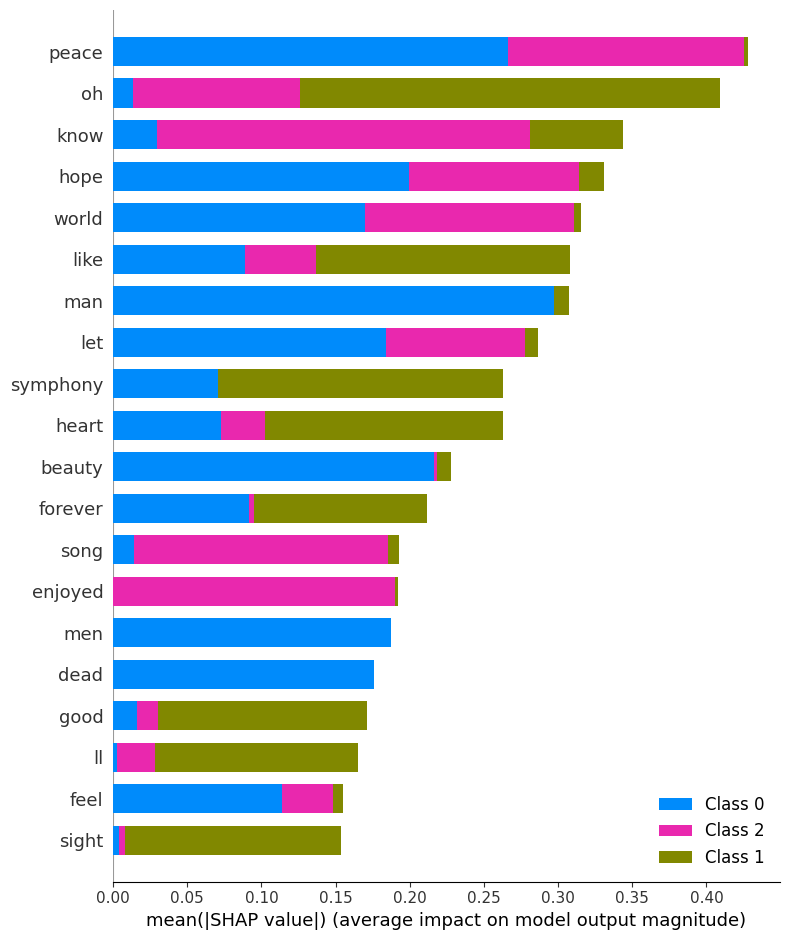

In [25]:
### INTERPRETABILITY - SHAP VALUES

explainer_111 = shap.Explainer(classifier_111.classifier)

if hasattr(X_test_poetry_111, "toarray"):
    X_test_poetry_111 = X_test_poetry_111.toarray()

# Calculate SHAP values
shap_values_111 = explainer_111(X_test_poetry_111)


# Visualize the SHAP values
shap.summary_plot(shap_values_111, X_test_poetry_111, feature_names=dim_names_111)

## **CLASSIFICATION USING TF-IDF & RANDOM FOREST**

In [26]:
ID_EXPERIMENT = 121

In [27]:
### EMBEDDING

embedding_121 = TfIdfEmbedding(ID_EXPERIMENT)

embedding_121.fit(X=X_train_poetry)

X_train_poetry_121 = embedding_121.transform(X=X_train_poetry)
X_test_poetry_121 = embedding_121.transform(X=X_test_poetry)
X_test_essay_121 = embedding_121.transform(X=X_test_essay)
X_test_story_121 = embedding_121.transform(X=X_test_story)

In [28]:
### CLASSIFIER

classifier_121 = RFClassifier(ID_EXPERIMENT)

classifier_121.train(X_train=X_train_poetry_121, y_train=y_train_poetry)

metrics_poetry_121 = classifier_121.evaluate(X_test_poetry_121, y_test_poetry)
metrics_essay_121 = classifier_121.evaluate(X_test_essay_121, y_test_essay)
metrics_story_121 = classifier_121.evaluate(X_test_story_121, y_test_story)

print(f"Metrics on poetry: {metrics_poetry_121}")
print(f"Metrics on essay: {metrics_essay_121}")
print(f"Metrics on story: {metrics_story_121}")

Metrics on poetry: {'accuracy': 0.9616477272727273, 'precision': 0.47511614580135486, 'recall': 0.6688727624576681, 'f1': 0.5293193216562635}
Metrics on essay: {'accuracy': 0.8929889298892989, 'precision': 0.37318007662835245, 'recall': 0.49055330634278, 'f1': 0.41019872515935507}
Metrics on story: {'accuracy': 0.41818181818181815, 'precision': 0.43703703703703706, 'recall': 0.41111111111111115, 'f1': 0.3094017094017094}


## **CLASSIFICATION USING TF-IDF & NAIVE BAYES**

In [29]:
ID_EXPERIMENT = 131

In [30]:
### EMBEDDING

embedding_131 = TfIdfEmbedding(ID_EXPERIMENT)

embedding_131.fit(X=X_train_poetry)

X_train_poetry_131 = embedding_131.transform(X=X_train_poetry)
X_test_poetry_131 = embedding_131.transform(X=X_test_poetry)
X_test_essay_131 = embedding_131.transform(X=X_test_essay)
X_test_story_131 = embedding_131.transform(X=X_test_story)

In [31]:
### CLASSIFIER

classifier_131 = NBClassifier(ID_EXPERIMENT)

classifier_131.train(X_train=X_train_poetry_131, y_train=y_train_poetry)

metrics_poetry_131 = classifier_131.evaluate(X_test_poetry_131, y_test_poetry)
metrics_essay_131 = classifier_131.evaluate(X_test_essay_131, y_test_essay)
metrics_story_131 = classifier_131.evaluate(X_test_story_131, y_test_story)

print(f"Metrics on poetry: {metrics_poetry_131}")
print(f"Metrics on essay: {metrics_essay_131}")
print(f"Metrics on story: {metrics_story_131}")

Metrics on poetry: {'accuracy': 0.40980113636363635, 'precision': 0.3753844324452876, 'recall': 0.693284954039671, 'f1': 0.2648669833779901}
Metrics on essay: {'accuracy': 0.8487084870848709, 'precision': 0.6962962962962963, 'recall': 0.6536437246963563, 'f1': 0.40396441062300625}
Metrics on story: {'accuracy': 0.6363636363636364, 'precision': 0.4052910052910053, 'recall': 0.4777777777777778, 'f1': 0.4385392385392386}
